In [1]:
# required Python imports
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import funciones as f

from scipy.spatial.transform import Rotation as rot
from scipy.optimize import minimize

# New approach to estimate the CPO

## 1. Reference system

### 1.1 The spherical coordinate system

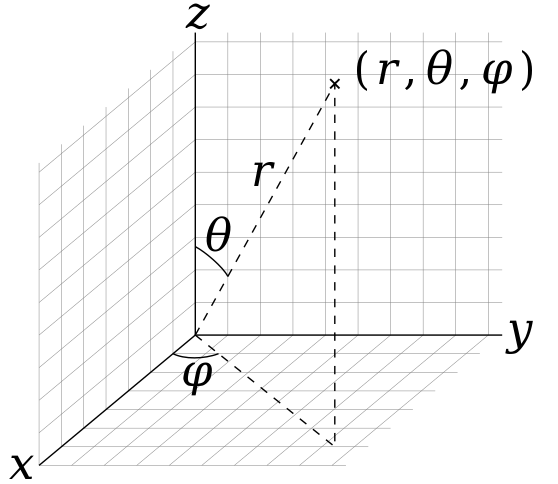

Spherical coordinates $(r, \theta, \varphi)$ as used in physics (ISO 80000-2:2019), being $r$ the radial distance (distance to origin), polar angle $\theta$ (theta) (angle with respect to polar/zenith z-axis), and azimuthal angle $\varphi$ or $\phi$ (phi) (angle of rotation from the initial meridian plane).

> **Important note**: the angles $\theta$ and $\varphi$/$\phi$ in Asimov et al. (2006) are interchanged with respect to the convention used in physics (see https://en.wikipedia.org/wiki/Spherical_coordinate_system). To avoid confusion, perhaps it would be a good idea to rename them (alpha and beta?) since strictly speaking they are angles with respect to crystallographic axes, not to the reference system (although later we will make them coincide).

### 1.2 Set the FTIR reference frame

To estimate the orientation of the crystals in the FTIR we will have to consider the following reference frames to establish a consistent coordinate frame:

- the microscope stage/sample pair
- the position of the reference transmittance envelope with respect to the reference system of the microscope
- the position of the crystal elements (axes, planes, etc.) with respect to the transmitance envelope

We start by defining that all coordinate systems used will be right handed, which also implies the right hand rule for the sense of rotations (positive rotation counter-clockwise). To determine the full orientation of a crystal, it is necessary to define a Cartesian reference frame for the crystal lattice. The unit cell is commonly described using three lengths, $a$, $b$ and $c$ and three angles $α$, $β$, $γ$ as depicted in the figure below. For a general case:

- $a$, $b$ and $c$ form a right handed set.
- $c$ is parallel always to the $z$ axis.
- $b$ lies in the $y$-$z$ plane, at an angle $α$ to $c$
- $a$ is pointed such that it is an angle $β$ to $c$ and $γ$ to $b$

![EBSD_ref_frame](https://raw.githubusercontent.com/bertopadron/FTIR-EBSD/main/notebooks2learn/imgs/EBSD_unit_cell_convention.png)

As olivine is orthorhombic, the axes defining the olivine unit cell are perpendicular to each other and thus the $c$-axis is parallel to $z$, the $a$-axis is parallel to $x$, and the $b$-axis is parallel to $y$. With this reference frame, the transmittance figure in our coordinate system is as follows:

TODO → ADD FIGURE


In [2]:
# check that a phi (azimuth) angle of 0 and a theta of 90 is the coordinates (1,0,0)
f.sph2cart(1, azimuth=0)

(1.0, 0.0, 6.123233995736766e-17)

In [3]:
# check that a phi (azimuth) angle of 90 and a theta (polar) of 90 is the coordinates (0,1,0)
f.sph2cart(1, azimuth=np.deg2rad(90), polar=np.deg2rad(90))

(6.123233995736766e-17, 1.0, 6.123233995736766e-17)

In [4]:
# check that for a theta (polar) angle of 0, whatever the phi (azimuth) angle, the coordinate is (0,0,1)
for angle in range(0, 90, 20):
    print(f'azimuth = {angle}, {f.sph2cart(1, azimuth=np.deg2rad(angle), polar=0)}')

azimuth = 0, (0.0, 0.0, 1.0)
azimuth = 20, (0.0, 0.0, 1.0)
azimuth = 40, (0.0, 0.0, 1.0)
azimuth = 60, (0.0, 0.0, 1.0)
azimuth = 80, (0.0, 0.0, 1.0)


### 1.3 Reference transmittance envelope

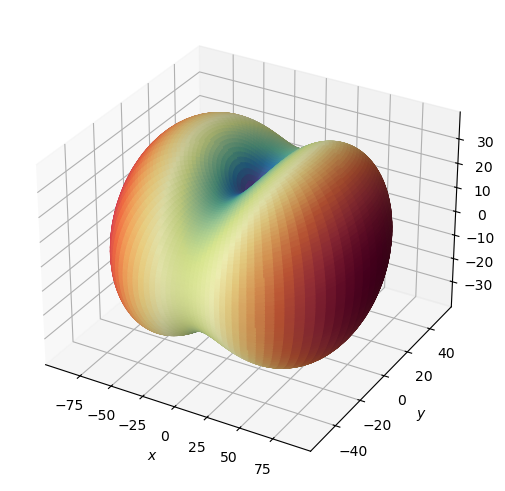

In [5]:
# generate a mesh of spherical/polar coordinates
polar, azimuths = f.regular_S2_grid(n_squared=100)

# estimate T values
T = f.Tvalues(trans=(90, 50, 20), azimuth=azimuths, polar=polar)

# convert from spherical to cartesian coordinates
x, y, z = f.sph2cart(T, azimuths, polar)

# normalize colors for T values to max and min values
Tmax, Tmin = T.max(), T.min()
Tcolors = (T - Tmin) / (Tmax - Tmin)

# make figure
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, constrained_layout=True)
ax.plot_surface(x, y, z, rstride=1, cstride=1, facecolors=cm.Spectral_r(Tcolors))
_ = ax.set_xlabel(r'$x$'), ax.set_ylabel(r'$y$'), ax.set_zlabel(r'$z$')

This would be the reference transmittance envelope for olivine for a given thickness and wavelength. Note that the maximum value (90), corresponding to $T_a$, alings with the $x$ direction in Cartesian space, and the minimum value (20), corresponding to $T_c$, alings with $z$ direction, as established in the previous figure.

So we now have our olivine positioned with crystallographic a-axis a aligned with the x axis, crystallographic b-axis aligned with the y axis and crystallographic c-axis aligned with the z axis. Given these premises, the approach to determine the crystallographic orientation from a few transmittance measurements is as follows.

## 2. The procedure (pseudocode)

### Step 1. Make measurements

Estimate the transmission values on the microscope at different angles respect to the polarization direction. If the polariser is aligned with the x-axis and measurements are taken in the xy-plane, it would be:

$$
(T, azimuth, polar) == (T, \varphi, \theta)
$$

where $T$ is the transmission measured, _azimuth_ ($\varphi$) is the angle in degrees between the polarizer (E-vector) and a reference within the sample (for example the large side of the sample or whatever suits us), and _polar_ ($\theta$) is the polar angle that in this case is a constant (90 degrees). In practice we will measure for example:

$$
(T_1, 0), (T_2, 20), (T3, 30), ... , (T_n, 0≥angle<180)
$$

If we need to convert these values into Cartesian coordinates, we use the function ``sph2cart()``, for example:

In [6]:
# sph2cart convert from spherical/polar (magnitude, azimuth, polar) to cartesian coordinates.
# If the polar angle is not given, the coordinate is assumed to lie on the XY plane.
# angles must be provided in radians!
print(f'for T=35 and azimuth=45, the coordinates are: {f.sph2cart(35, azimuth=np.deg2rad(45))}')
print(f'for T=60 and azimuth=90, the coordinates are: {f.sph2cart(60, azimuth=np.deg2rad(90))}')

for T=35 and azimuth=45, the coordinates are: (24.748737341529164, 24.748737341529164, 2.1431318985078682e-15)
for T=60 and azimuth=90, the coordinates are: (3.67394039744206e-15, 60.0, 3.67394039744206e-15)


### Step 2. Check if measurements lie on the surface of the reference envelope.

According to Asimov et al. (2006), we can estimate $T$ for any direction using the simplified transmission equation as a function of $\theta$, $\varphi$ as follows:

$$
T = T_a \cdot cos^2\varphi sin^2\theta + T_b \cdot sin^2\varphi sin^2\theta + T_c \cdot cos^2\theta
$$

> remember that in our reference system $\theta$ is the **polar angle** and $\varphi$ the **azimuth angle**

as we know the $T_a, T_b, T_c$ values and we know $\theta$, and $\varphi$ from our measures, we need to ensure that

$$
(|T_{measured} - T_{theoretical}|)^2 = 0
$$

is fulfilled for all the measures taken.

### Step 3. Inverse calculation

If this equality above is not satisfied (within a reasonable tolerance), we need to convert these measurements to Cartesian coordinates (i.e. points), rotate these points (e.g. using Euler angles), convert back to spherical coordinates and check again. This process should be repeated until the solution converges. The rotation required to fulfil this condition is the orientation of the olivine crystal with respect to the established reference system.

### Pseudocode:

- Apply Step 2
- If solution converge: no rotation is nedeed and the olivine crystal is aligned as in the reference frame (e.g. Euler angle=(0,0,0))
- Else:
    - convert measures to cartesian coordinates
    - apply rotation using Eules angles (Bunge convention)
    - convert bak to spherical coordinates
    - check and continue until solution converges
    - return the Euler angles that orientate the olivine crystal

## 3. Design the minimization procedure

TODO

In [7]:
# starting points, points are: (T, azimuth)
point_a = (np.deg2rad(0), 50)
point_b = (np.deg2rad(45), 45)
point_c = (np.deg2rad(90), 60)

not checked yet! **re-implementation, work in progress**

In [8]:
def objective_function(euler_ang, measurements, params):
    """
    Objective function to minimize the difference between
    measured and theoretical T values
    """
    # extract variables
    Ta, Tb, Tc = params
    T_measured = measurements[:, 0]
    azimuths = np.deg2rad(measurements[:, 1])
    polar = np.deg2rad(measurements[:, 2])

    # convert from spherical to cartesian coordinates
    x, y, z = f.sph2cart(T_measured, azimuths, polar)
    
    # apply rotation using Eules angles (Bunge convention)
    x2, y2, z2 = f.rotate(coordinates=(x, y, z), euler_ang=euler_ang)
    
    # convert back to spherical coordinates
    T_measured, azimuths, polar = f.cart2sph(x2, y2, z2)
    
    # estimate theoretical T values
    T_theoretical = f.Tvalues(trans=(Ta, Tb, Tc), azimuth=azimuths, polar=polar)

    return np.sum(np.abs(T_measured - T_theoretical))**2

def check_points_on_surface(measurements, params, tolerance=None):
    """
    Given a set of points in 3D space, determine if they fall on the surface
    defined by the function T. If the points do not fall on the surface,
    apply a rotation to the points and check again until the points fall on
    the surface. Return the Euler angles that rotate the points to the surface.

    Parameters
    ----------
    measurements : numpy array
        The measurements, where each tuple contains (T, azimuths, polar).
    params : tuple of size 3
        tuple containing the transmission values along a-axis (Ta),
        b-axis (Tb), and c-axis (Tc). -> (Ta, Tb, Tc)
    tolerance : float or None
        tolerance for determining if a point is on the surface

    Returns
    -------
    tuple of size 3
        tuple containing the Euler angles in degrees for rotating
        the points to the surface

    """
    # set initial conditions
    bounds = [(0, 90), (0, 180), (0, 90)]
    euler_ang = (45, 90, 45)  # first guess

    # minimise
    result = minimize(fun=objective_function,
                      x0=euler_ang,
                      args=(measurements, params),
                      bounds=bounds,
                      tol=tolerance)
    
    print(f'Orientation: {np.around(result.x, 1)}')
    return result


def check_points_on_surface2(measurements, params, num_guesses=10, tolerance=None):
    """
    Given a set of points in 3D space, determine if they fall on the surface
    defined by the function T. If the points do not fall on the surface,
    apply a rotation to the points and check again until the points fall on
    the surface. Return the Euler angles that rotate the points to the surface.

    Parameters
    ----------
    measurements : numpy array
        The measurements, where each tuple contains (T, azimuths, polar).
    params : tuple of size 3
        tuple containing the transmission values along a-axis (Ta),
        b-axis (Tb), and c-axis (Tc). -> (Ta, Tb, Tc)
    num_guesses : int
        Number of initial guesses to try.
    tolerance : float or None
        tolerance for determining if a point is on the surface

    Returns
    -------
    tuple of size 3
        tuple containing the Euler angles in degrees for rotating
        the points to the surface
    """

    best_result = None
    best_objective_value = float('inf')

    for _ in range(num_guesses):
        # Generate a random initial guess within the specified bounds
        euler_ang = np.around(np.random.uniform([0, 0, 0], [90, 180, 90]), 0)

        # set initial conditions
        bounds = [(0, 90), (0, 180), (0, 90)]

        # minimise
        result = minimize(fun=objective_function,
                          x0=euler_ang,
                          args=(measurements, params),
                          bounds=bounds,
                          tol=tolerance)

        # Update the best result if the current one is better
        if result.fun < best_objective_value:
            best_objective_value = result.fun
            best_result = result

    print(f'Best Orientation: {np.around(best_result.x, 1)}')
    return best_result

In [9]:
np.around(np.random.uniform([0, 0, 0], [90, 180, 90]), 0)

array([ 12., 115.,  83.])

In [10]:
# test
#np.sum(np.abs(np.array([1.1,2,3,4,5]) - np.array([1,2,3,4,5])))**2

Define some tests

In [11]:
# vealues for an euler orientation of [75 90 45]
test1 = np.array([[36.5, 0.3, 90],
                  [45.9, 17.9, 90],
                  [51.9, 35.9, 90],
                  [51.9, 54.1, 90],
                  [45.9, 72.1, 90 ],
                  [36.3, 90.0, 90]])

In [12]:
# vealues for an euler orientation of [0 0 0]
test2 = np.array([[90.0, 0.0, 90],
                  [86.2, 18.09, 90],
                  [76.1, 36.1, 90],
                  [63.7, 54.1, 90],
                  [53.8, 72.1, 90 ],
                  [50.0, 90.2, 90]])

In [13]:
test3 = np.array([[90.0, 0.0, 90],
                  [50.0, 90.0, 90],
                  [20.0, 0.0, 0.0]])

In [14]:
# manual test
x, y, z = f.sph2cart(test2[:, 0], azimuth=np.deg2rad(test2[:, 1]), polar=np.deg2rad(test2[:, 2]))
x2, y2, z2 = f.rotate(coordinates=(x, y, z), euler_ang=(0, 0, 0))
T_measured, azimuths, polar = f.cart2sph(x2, y2, z2)
T_theoretical = f.Tvalues(trans=(90, 50, 20), azimuth=azimuths, polar=polar)

print('     T values (measured)', T_measured)
print('  T values (theoretical)', T_theoretical)
print('        azimuthal angles', np.rad2deg(azimuths))
print('inclination/polar angles', np.rad2deg(polar))
print(f'                   diff: {np.sum(np.abs(T_measured - T_theoretical))**2:.2f}')

     T values (measured) [[90.  86.2 76.1 63.7 53.8 50. ]]
  T values (theoretical) [[90.         86.14332846 76.1139061  63.75330163 53.77872362 50.00048739]]
        azimuthal angles [[ 0.   18.09 36.1  54.1  72.1  90.2 ]]
inclination/polar angles [[90. 90. 90. 90. 90. 90.]]
                   diff: 0.02


In [15]:
check_points_on_surface(measurements=test1, params=(90, 50, 20))

Orientation: [  0.  125.2  80.5]


  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 931.7761894931936
        x: [ 0.000e+00  1.252e+02  8.052e+01]
      nit: 23
      jac: [ 2.936e+01  6.172e+01  2.897e+01]
     nfev: 696
     njev: 174
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>

In [16]:
check_points_on_surface2(measurements=test2, params=(90, 50, 20), num_guesses=10)

Best Orientation: [0.  0.3 0. ]


  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 0.018151244504702912
        x: [ 1.029e-02  2.548e-01  1.035e-02]
      nit: 21
      jac: [ 2.232e-01 -3.860e-04  2.232e-01]
     nfev: 372
     njev: 93
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>

Why the minimisation do not converge? See below

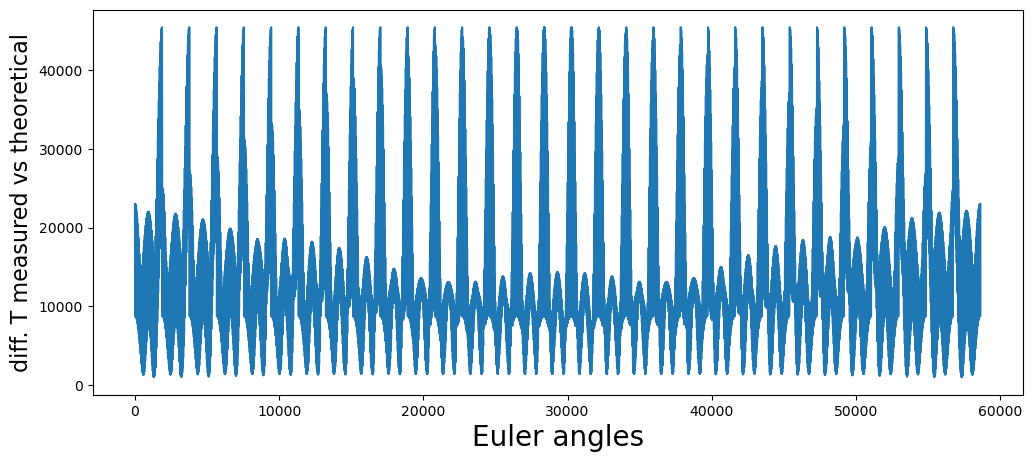

In [17]:
def plot():
    euler = f.explore_Euler_space(step=3)
    diff = np.empty(euler.shape[0])

    for index, euler_ang in enumerate(euler):
        val = objective_function(euler_ang, test1, params=(90, 50, 20))
        diff[index] = val
    
    fig, ax = plt.subplots(figsize=(12,5))
    ax.plot(np.arange(len(diff)), diff)
    ax.set_xlabel('Euler angles', fontsize=20)
    ax.set_ylabel('diff. T measured vs theoretical', fontsize=16)

    return None

plot()

As can be seen when exploring the space of Euler angles, there are multiple local minimums (62 minimums for test 1!) and this causes most minimisation algorithms to fail even when exploring the space with different initial guess values. A first non-optimised solution is to use a brute-force algorithm that explores the space of Euler angles with a defined precision (step size) as follows:

In [18]:
def brute_force():
    euler = f.explore_Euler_space(step=2)
    diff = np.empty(euler.shape[0])

    for index, euler_ang in enumerate(euler):
        val = objective_function(euler_ang, test3, params=(90, 50, 20))
        diff[index] = val
    
        #print(f" Euler {euler_ang}, diff: {val:.0f}")
    
    return euler[diff.argmin()]

brute_force()

array([0, 0, 0])

In [20]:
# tweak the brute force approach to obtain the 10 smallest values
def brute_force2():
    euler = f.explore_Euler_space(step=1)  # step=1 will take more than 1 min to find the solution!
    diff = np.empty(euler.shape[0])

    for index, euler_ang in enumerate(euler):
        val = objective_function(euler_ang, test2, params=(90, 50, 20))
        diff[index] = val
    
    indices_of_smallest_values = np.argsort(diff)[:10]

    for index in indices_of_smallest_values:
        print(f'diff: {diff[index]:.5f}; Euler angles: {euler[index]}')

    return None

brute_force2()

diff: 0.02121; Euler angles: [0 0 0]
diff: 0.02121; Euler angles: [ 46 180  46]
diff: 0.02121; Euler angles: [ 45 180  45]
diff: 0.02121; Euler angles: [ 44 180  44]
diff: 0.02121; Euler angles: [ 43 180  43]
diff: 0.02121; Euler angles: [ 42 180  42]
diff: 0.02121; Euler angles: [ 40 180  40]
diff: 0.02121; Euler angles: [ 39 180  39]
diff: 0.02121; Euler angles: [ 38 180  38]
diff: 0.02121; Euler angles: [ 37 180  37]


There are several optimization algorithms and strategies to handle such situations more efficiently, including: (i) Simulated Annealing, (ii) differential_evolution (global optimization), (iii) Particle Swarm Optimization (PSO), or (iv) basin-hopping algorithm among others.

> Other problems to fix: when using the test1 even the brute-force algorithm do not converge (minimum diffs are above 900!) so something is wrong with the data, the algorithm of we need more than 10 points? In other cases (test2), several orientations have similar minimas so that no unique solution exists? to follow-up

## 4. How to generate a toy dataset to test the algorithm

1. Generate a dataset of euler angles
2. Estimate values on the XY plane using the ``extract_XY_section_fast2()`` for each orientation (including coordinates, T and angle)
3. Pick six values for each section and store (angles=[0, 18, 36, 54, 72, 90])
4. Use this dataset to test the implementation above

we are going to store these database in a SimpleNameSpace object where:
- ``database.euler`` contains the euler angles.
- ``database.T_values`` contains the transmissión values.
- ``database.azimuths`` contains the azimuth angles.

> For the procedure see the notebook: **gen_toy_database**